You’re tasked with forecasting a financial index (e.g., S&P 500) for clients who want to manage their investment strategies and budgeting. Accuracy helps inform high-level decisions.

[*********************100%***********************]  1 of 1 completed


S&P 500 Dataset:
Price             Close         High          Low         Open      Volume
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC       ^GSPC
Date                                                                      
2013-01-02  1462.420044  1462.430054  1426.189941  1426.189941  4202600000
2013-01-03  1459.369995  1465.469971  1455.530029  1462.420044  3829730000
2013-01-04  1466.469971  1467.939941  1458.989990  1459.369995  3424290000
2013-01-07  1461.890015  1466.469971  1456.619995  1466.469971  3304970000
2013-01-08  1457.150024  1461.890015  1451.640015  1461.890015  3601600000

Dataset information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2518 entries, 2013-01-02 to 2022-12-30
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (Close, ^GSPC)   2518 non-null   float64
 1   (High, ^GSPC)    2518 non-null   float64
 2   (Low, ^GSPC)     2518 non-null   float64
 3   (O

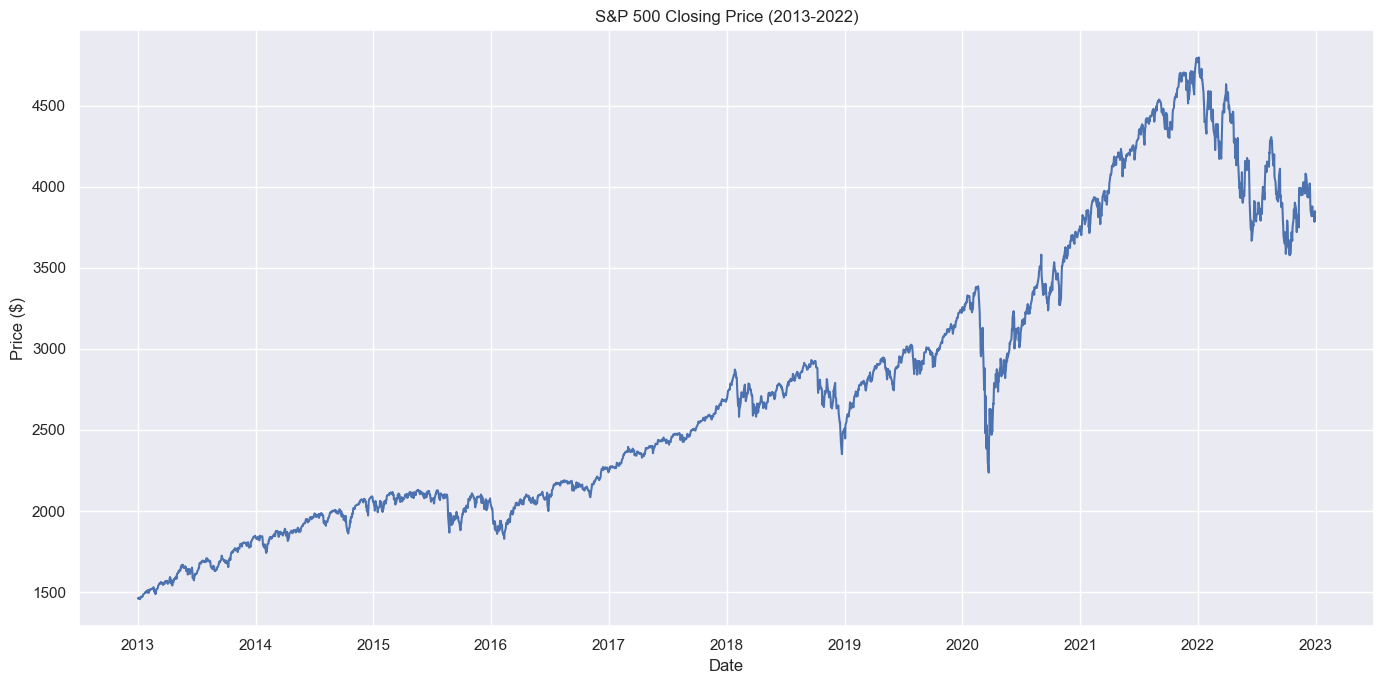


Selected time series shape: (2518, 1)


In [28]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import yfinance as yf
import warnings
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_theme()

# Download S&P 500 data for the last 10 years
sp500 = yf.download('^GSPC', start='2013-01-01', end='2022-12-31')

# Display the first few rows of the dataset
print("S&P 500 Dataset:")
print(sp500.head())

# Display basic information about the dataset
print("\nDataset information:")
print(sp500.info())

# Calculate basic summary statistics
print("\nSummary Statistics:")
print(sp500['Close'].describe())

# Check for missing values
print("\nMissing values in each column:")
print(sp500.isnull().sum())

# Plot the closing price
plt.figure(figsize=(14, 7))
plt.plot(sp500.index, sp500['Close'])
plt.title('S&P 500 Closing Price (2013-2022)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Select the closing price as our primary time series for analysis
ts_data = sp500['Close']
print("\nSelected time series shape:", ts_data.shape)

Perform rolling statistics


First 12-month Rolling Mean (rounded): 1467.4

First 12-month Rolling Std Dev (rounded): 7.1


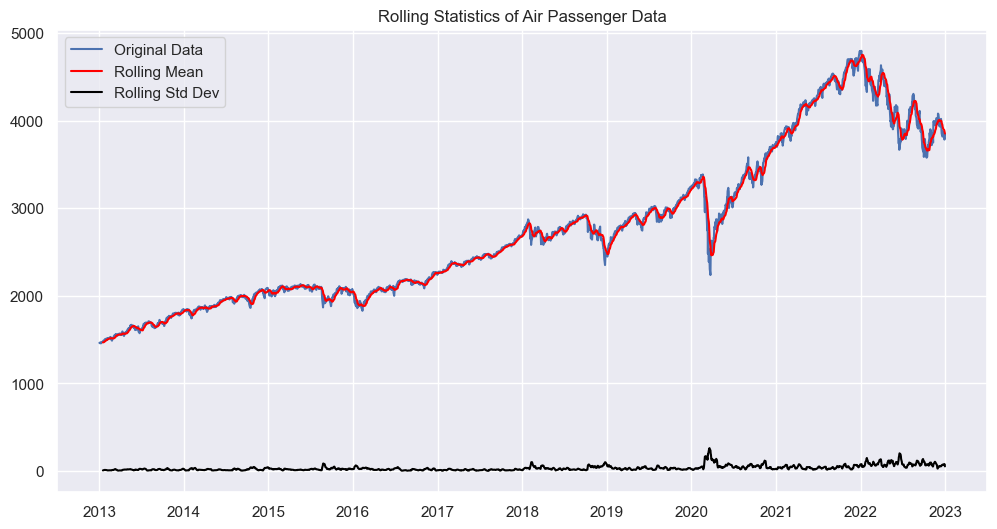

In [3]:
from statsmodels.tsa.stattools import adfuller

# rolling mean and standard deviation
rolling_mean = ts_data.rolling(window=12).mean()
rolling_std = ts_data.rolling(window=12).std()

# find first non-NA value, round to 1 decimal place
first_mean = round(rolling_mean.dropna().iloc[0, 0], 1)
first_std = round(rolling_std.dropna().iloc[0, 0], 1)

print("\nFirst 12-month Rolling Mean (rounded):", first_mean)
print("\nFirst 12-month Rolling Std Dev (rounded):", first_std)

# Plot the Rolling Statistics
plt.figure(figsize=(12, 6))
plt.plot(ts_data, label='Original Data')
plt.plot(rolling_mean, label='Rolling Mean', color='red')
plt.plot(rolling_std, label='Rolling Std Dev', color='black')
plt.legend()
plt.title("Rolling Statistics of Air Passenger Data")
plt.show()


p-value: 0.7417

ADF Statistic: -1.0312


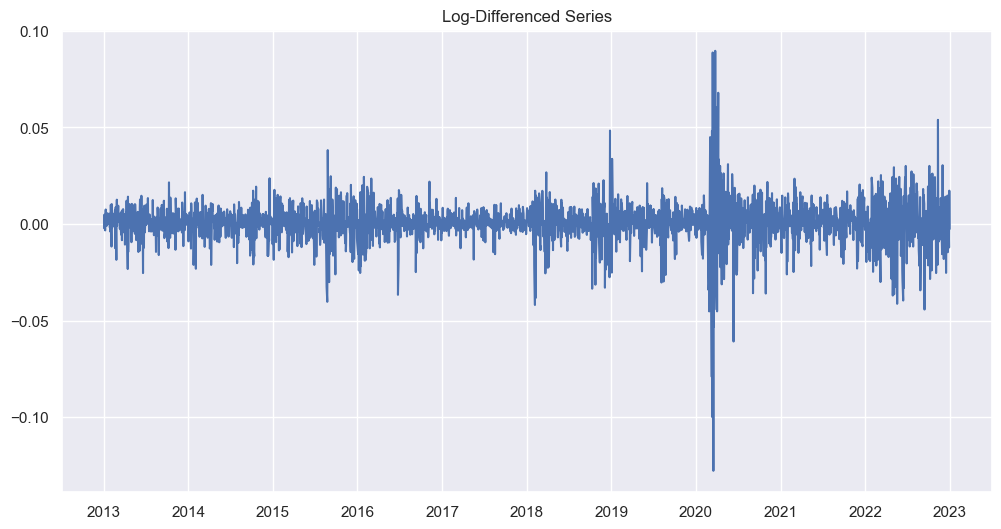


ADF Statistic (log-differenced): -15.8374

p-value (log-differenced): 9.782658846188109e-29


In [7]:
# Augmented Dickey-Fuller test to see if the series is stationary.
# If needed, apply log transformations or differencing to stabilize trends and variance.

# Test original data
result = adfuller(ts_data.dropna())
print("\np-value:", round(result[1], 4))
print("\nADF Statistic:", round(result[0], 4))

# Transform if non-stationary
ts_log = np.log(ts_data)
ts_log_diff = ts_log.diff().dropna()

# plot logged data
plt.figure(figsize=(12, 6))
plt.plot(ts_log_diff)
plt.title("Log-Differenced Series")
plt.show()

# test logged data
result_diff = adfuller(ts_log_diff)
print("\nADF Statistic (log-differenced):", round(result_diff[0], 4))
print("\np-value (log-differenced):", result_diff[1])

The ADF statistic before log transformation and differencing was -1.03 and the p-value was 0.7417. We failed to reject the null hypothesis that the data is non-stationary. 

After log transform and differencing the ADF stat is -15.8 and the p-value is almost 0. Therefore the null hypothesis that the data is non-stationary can be rejected, and we can conclude that it is now stationary.

Decompose your time series into trend, seasonal, and residual components.

Confirm whether seasonal patterns exist (e.g., monthly or quarterly cycles).

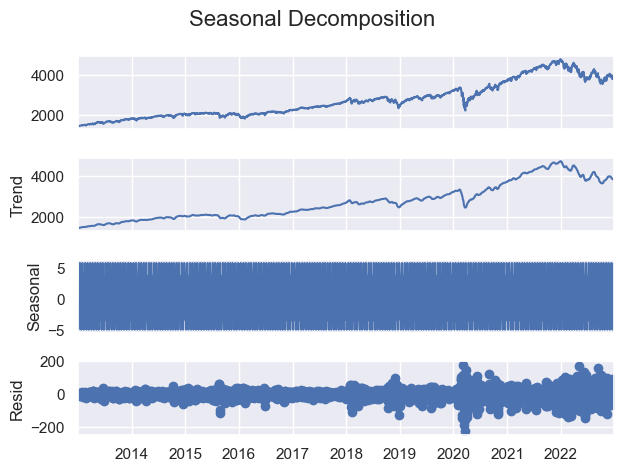

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Apply seasonal decomposition (assume monthly data with period=12)
decomposition = seasonal_decompose(ts_data, model='additive', period=12)

# Plot decomposition
decomposition.plot()
plt.suptitle("Seasonal Decomposition", fontsize=16)
plt.tight_layout()
plt.show()

The trend shows a smooth upward movement from 2013 to 2022. This aligns with the long-term market growth the S&P500 is famous for. The seasonal component is flat, showing no discernible repeating monthly or quarterly pattern. The residuals show noise around the trend. 

Reference ACF/PACF plots to choose between AR, MA, ARMA, or ARIMA models.

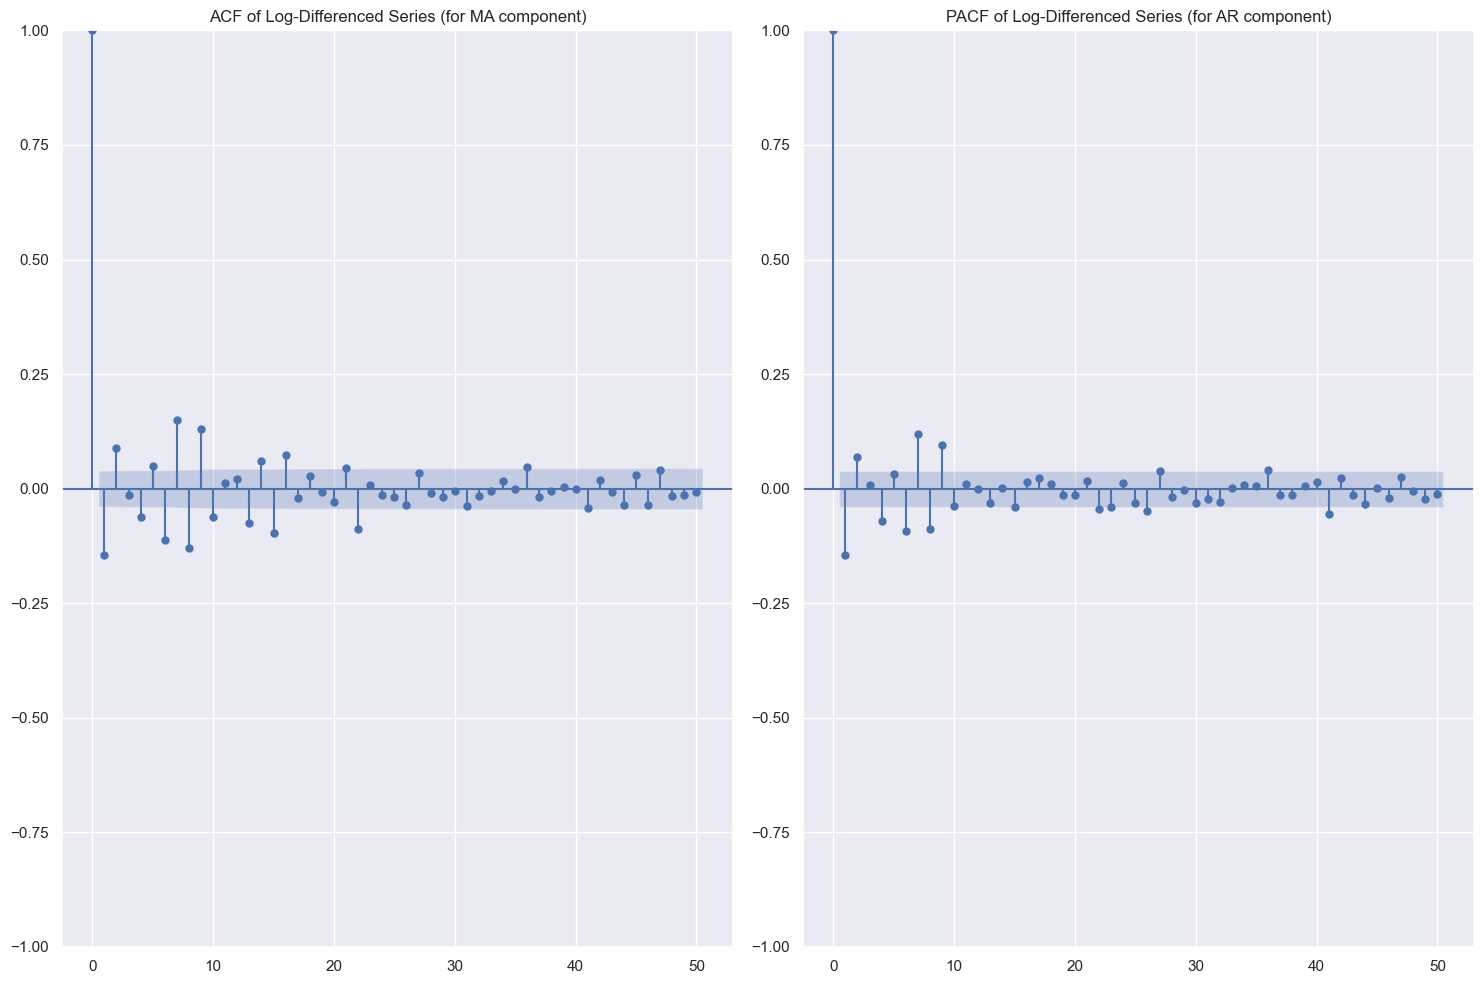

In [10]:
# plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

plot_acf(ts_log_diff, lags = 50, ax=axes[0])
axes[0].set_title('ACF of Log-Differenced Series (for MA component)')

plot_pacf(ts_log_diff, lags=50, ax=axes[1], method='ywm')
axes[1].set_title('PACF of Log-Differenced Series (for AR component)')

plt.tight_layout()
plt.show()

The ACF plot has a strong spike at lag 1, then drops quickly. The subsequent lags fall within the confidence bounds. This suggests MA(1) component, as the current value is a function of the previous error only.

The PACF plot has a strong spike at lag 1, then drops off and stays low. This suggests AR(1) component, as the current value depends directly only on the immediately preceding value.

Therefore ARIMA(p=1, d=1, q=1) where p is the AR order (Autoregressive), the number of lag observations from PACF, d is the differencing order, or the number of times the data needs to be differenced to become stationary, and q is the MA order (moving average), or the number of lagged forecast errors (from ACF).


In [ ]:
# define and train an ARIMA model (1, 1, 1) based on ACF/PACF analysis

# define and fit ARIMA model
log_series = ts_log
model = ARIMA(log_series, order=(1, 1, 1))
model_fit = model.fit()

# compute Akaike information criterion (AIC) and Bayesian information criterion (BIC) for model evaluation
aic = round(model_fit.aic, 2)
bic = round(model_fit.bic, 2)
print(f"AIC: {aic}\nBIC: {bic}")

AIC: -15539.47
BIC: -15521.98


In [20]:
# fit multiple models
# find best AIC criterion by searching over a range of p, d, q values

warnings.filterwarnings("ignore")

best_aic = float("inf")
best_order = None
best_model = None

# Define search range
p_values = range(0, 4)   # try AR terms 0 to 3
d_values = range(1, 2)   # usually 1 after differencing
q_values = range(0, 4)   # try MA terms 0 to 3

for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = ARIMA(ts_log, order=(p, d, q))
                model_fit = model.fit()
                aic = model_fit.aic
                if aic < best_aic:
                    best_aic = aic
                    best_order = (p, d, q)
                    best_model = model_fit
            except:
                continue

print(f"Best ARIMA order: {best_order}")
print(f"Best AIC: {round(best_aic, 2)}")

Best ARIMA order: (3, 1, 2)
Best AIC: -15655.48


In [21]:
# fit multiple models
# find best BIC criterion by searching over a range of p, d, q values

warnings.filterwarnings("ignore")

best_bic = float("inf")
best_order_bic = None
best_model_bic = None

# Define search range
p_values = range(0, 4)   # try AR terms 0 to 3
d_values = range(1, 2)   # usually 1 after differencing
q_values = range(0, 4)   # try MA terms 0 to 3

for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = ARIMA(ts_log, order=(p, d, q))
                model_fit = model.fit()
                bic = model_fit.bic
                if bic < best_bic:
                    best_bic = bic
                    best_order_bic = (p, d, q)
                    best_model_bic = model_fit
            except:
                continue

print(f"Best ARIMA order: {best_order_bic}")
print(f"Best BIC: {round(best_bic, 2)}")

Best ARIMA order: (3, 1, 2)
Best BIC: -15620.49


The best ARIMA order (p, d, q) = (3, 1, 2) and best criterion is AIC which is lower than BIC.

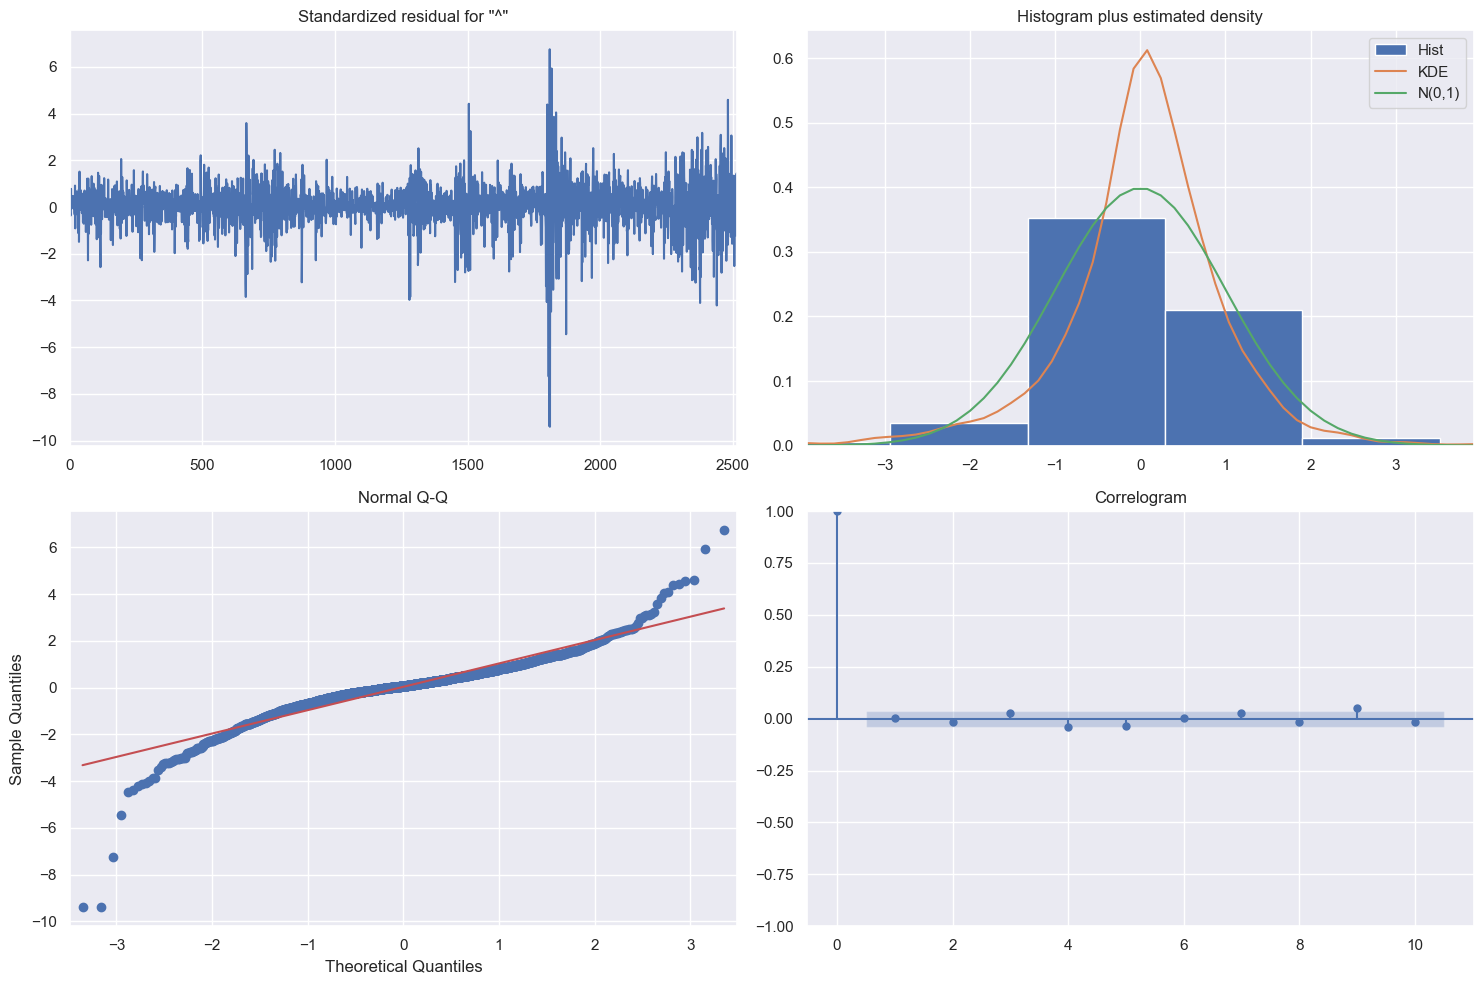

In [22]:
# plot model diagnostics to analyze residuals and model filter
best_model.plot_diagnostics(figsize=(15, 10))
plt.tight_layout()
plt.show()

Standardized residuals shows random white noise with no clear pattern, and a big spike in 2020 due to covid. The histogram + KDE shows a bellshaped symmetric curve that overlaps with the normal distribution line. The normal Q-Q plot shows residuals lying along the red line, except at the tail ends, showing that they are mostly normally distributed. The plot is very close to the red line except at the tail ends. The correlogram checks for remaining autocorrelation in the residuals. Most lags are within the blue confidence band suggesting no significant autocorrelation left.

In [ ]:
# forecast next 12 months (already fitted model)
forecast_result = best_model.get_forecast(steps=12)

# extract predicted log values and confidence intervals
log_forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# revert to original scale
forecast = np.exp(log_forecast)
conf_int_exp = np.exp(conf_int)

# build future dates
last_date = ts_data.index[-1]
# build out future dates 12 months in the future
future_dates = pd.date_range(start = last_date + pd.DateOffset(months=1), periods=12, freq='MS')

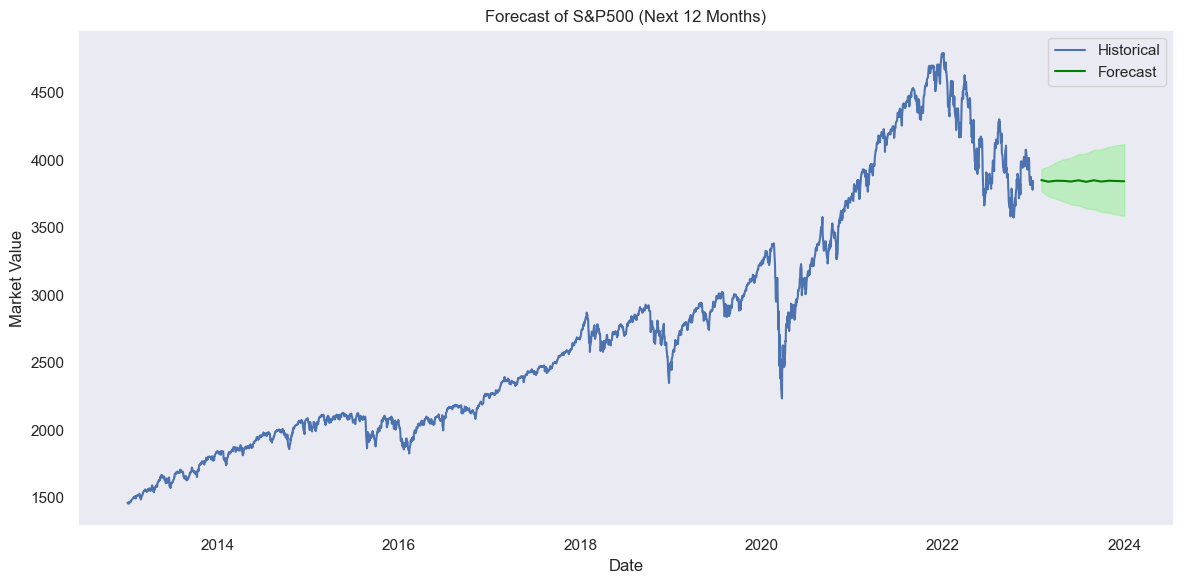

In [26]:
# plot predictions vs actual data
# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(ts_data, label='Historical')
plt.plot(future_dates, forecast, label='Forecast', color='green')
plt.fill_between(future_dates, 
                 conf_int_exp.iloc[:, 0], 
                 conf_int_exp.iloc[:, 1], 
                 color='lightgreen', alpha=0.5)
plt.title("Forecast of S&P500 (Next 12 Months)")
plt.xlabel("Date")
plt.ylabel("Market Value")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

The ARIMA (3, 1, 2) model expects a modest continuation of the recent level, not explosive growth or collapse. This model forecasts only based on historical price patterns, not external factors like inflation, government policy or current events.

In [35]:
# evaluate model performance
# calculate MAE, RMSE and MAPE

# Get in-sample predictions
log_predictions = best_model.predict(start=ts_log.index[0], end=ts_log.index[-1])  # Get predictions for the original time series range

# Instead of dropping the first value, align the predictions with true_values:
true_values = ts_data

# predictions = predictions[true_values.index]  # Align predictions with true_values index
predictions = np.exp(log_predictions)  # Revert log transformation

# Calculate error metrics
mae = mean_absolute_error(true_values, predictions)
rmse = np.sqrt(mean_squared_error(true_values, predictions))

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(true_values, predictions)

print(f"Mean absolute error: {round(mae, 2)}")
print(f"Root mean squared error: {round(rmse, 2)}")
print(f"Mean absolute percentage error: {round(mape, 2)}%")

Mean absolute error: 21.19
Root mean squared error: 43.82
Mean absolute percentage error: 37.39%


MAE is low considering the scale of the S&P500. The model misses on average $21.19, which is not bad for a market whose value is in the thousands.
RMSE penalizes larger errors more than MAE, suggesting occasional bigger deviations than MAE would predict for.
MAPE of ~37% seems high but this is a financial market that changes value drastically due to unpredictable world events and blockbuster news.